![Unidata organization logo](https://github.com/Unidata/metpy-ams-2023/raw/main/logos/unidata_logo_horizontal.png)

# Radar Data

## MetPy for your Data: Analyzing Meteorological Observations in Python

**About this Notebook**:

When we turn to working with radar data in Python, we'll be going beyond just MetPy. This notebook will introduce Py-ART (another package in the Python ecosystem in the atmospheric sciences) and use it to read Level 2 NEXRAD data from AWS S3.

## Table of Contents <a class="anchor" id="top"></a>

* [Activity 0: Import required packages](#step0)
* [Activity 1: Exploring the NEXRAD level 2 archive on AWS S3](#step1)
* [Activity 2: Loading a level 2 file with Py-ART](#step2)
* [Activity 3: Plotting radar data with matplotlib](#step3)
    * [Step 3a: Plotting a single moment](#step3a)
    * [Step 3b: Plotting mulitple scans/moments](#step3b)
* [Wrap-Up](#wrapup)

## Activity 0: Import required packages <a class="anchor" id="step0"></a>
[Top](#top)

First, we need to import all our required packages. In this notebook we're primarily working with:

- Py-ART, for reading NEXRAD level 2 data
- s3fs, for interacting with an S3 bucket in a filesystem-like way
- matplotlib, for plotting
- cartopy, for geographically-aware plotting
- MetPy, for county outlines

In [6]:
## CELL 0A
## INSTRUCTIONS: Run this cell

from datetime import datetime
import re
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import numpy as np
import pyart
import s3fs

# Suppress cartopy with shapely 2.0 warnings
warnings.filterwarnings('ignore', '.*geom_factory.*', DeprecationWarning)

## Activity 1: Exploring the NEXRAD level 2 archive on AWS S3<a class="anchor" id="step1"></a>
[Top](#top)

{todo comment about S3 bucket being best source for both archive and real-time radar data}

<div class="admonition alert alert-info">

<p class="admonition-title" style="font-weight:bold">Types and Formats of NEXRAD Data</p>

{todo disambiguate between level2, level3, radar moasics; provide links/external references; briefly mention non-NEXRAD data?}
    
In this notebook, we will be exclusively working with Level 2 data.

</div>

{todo brief comment about how S3 is an "object store" and why that matters, but that we can use convient tools to interact with this "bucket" just like a file collection}

While one could explore this `noaa-nexrad-level2` S3 bucket via [the web interface]( to browse for  (and [info page](https://registry.opendata.aws/noaa-nexrad/)), but primarily using fsspec for exploration here}

In [2]:
## CELL 1A
## INSTRUCTIONS: Run this cell

fs = s3fs.S3FileSystem(anon=True)
fs.ls('noaa-nexrad-level2')

['noaa-nexrad-level2/1970',
 'noaa-nexrad-level2/1991',
 'noaa-nexrad-level2/1992',
 'noaa-nexrad-level2/1993',
 'noaa-nexrad-level2/1994',
 'noaa-nexrad-level2/1995',
 'noaa-nexrad-level2/1996',
 'noaa-nexrad-level2/1997',
 'noaa-nexrad-level2/1998',
 'noaa-nexrad-level2/1999',
 'noaa-nexrad-level2/2000',
 'noaa-nexrad-level2/2001',
 'noaa-nexrad-level2/2002',
 'noaa-nexrad-level2/2003',
 'noaa-nexrad-level2/2004',
 'noaa-nexrad-level2/2005',
 'noaa-nexrad-level2/2006',
 'noaa-nexrad-level2/2007',
 'noaa-nexrad-level2/2008',
 'noaa-nexrad-level2/2009',
 'noaa-nexrad-level2/2010',
 'noaa-nexrad-level2/2011',
 'noaa-nexrad-level2/2012',
 'noaa-nexrad-level2/2013',
 'noaa-nexrad-level2/2014',
 'noaa-nexrad-level2/2015',
 'noaa-nexrad-level2/2016',
 'noaa-nexrad-level2/2017',
 'noaa-nexrad-level2/2018',
 'noaa-nexrad-level2/2019',
 'noaa-nexrad-level2/2020',
 'noaa-nexrad-level2/2021',
 'noaa-nexrad-level2/2022',
 'noaa-nexrad-level2/2023',
 'noaa-nexrad-level2/index.html']

{todo comment about structure of file paths/object keys}

`noaa-nexrad-level2/{yr}/{mo}/{dy}/{site}/{filename}`

where `{filename}` typically looks like:

* `{site}{yr}{mo}{dy}_{hr}{min}{sec}_V06`, for more recent data
* `{site}{yr}{mo}{dy}_{hr}{min}{sec}_V06.gz`, for slightly less recent data
* `{site}{yr}{mo}{dy}_{hr}{min}{sec}_V03.gz` or `{site}{yr}{mo}{dy}_{hr}{min}{sec}.gz`, for older data

{todo comment about always searching for filename and exact time from available list, rather than knowing exact file ahead-of-time, when first looking for data for a given location and time}

{todo prompt example cell below to query a list of available files from KFTG today}

In [3]:
## CELL 1B
## INSTRUCTIONS: Run this cell

now = datetime.now()
file_keys = fs.ls(f'noaa-nexrad-level2/{now:%Y}/{now:%m}/{now:%d}/KFTG/')

print(len(file_keys))
print(file_keys[-5:])

229
['noaa-nexrad-level2/2023/01/07/KFTG/KFTG20230107_233731_V06', 'noaa-nexrad-level2/2023/01/07/KFTG/KFTG20230107_234431_V06', 'noaa-nexrad-level2/2023/01/07/KFTG/KFTG20230107_235132_V06', 'noaa-nexrad-level2/2023/01/07/KFTG/KFTG20230107_235832_V06', 'noaa-nexrad-level2/2023/01/07/KFTG/KFTG20230107_235832_V06_MDM']


{todo try to connect the dots about searching for a file...could be done "manually", but could also be done with code!}

For example, still at KFTG, let's try to find the scan closest to 2013-09-12 01:00 UTC:

In [8]:
## CELL 1C
## INSTRUCTIONS: Run this cell

site = 'KFTG'
target = datetime(2013, 9, 12, 1, 0)
file_keys_on_day = fs.ls(f'noaa-nexrad-level2/{target:%Y}/{target:%m}/{target:%d}/{site}/')

def key_to_time_difference(key, target):
    # Search for the filename in the key
    if dt_group := re.search(r'[A-Z]{4}(\d{8}_\d{6})', key):
        return (target - datetime.strptime(dt_group.group(1), '%Y%m%d_%H%M%S')).total_seconds()
    else:
        return np.inf
    
nearest = min(file_keys_on_day, key=lambda k: abs(key_to_time_difference(k, target)))

print(nearest)

noaa-nexrad-level2/2013/09/12/KFTG/KFTG20130912_010204_V06.gz


<div class="admonition alert alert-warning">

<p class="admonition-title" style="font-weight:bold">Activity: Find Your Own Level 2 File</p>

todo: prompt for participants to search for this own file
    
todo: add list of interesting examples to get folks started

</div>

In [5]:
# ACTIVITY: Find Your Own File
# Adapt prior code or create your own to find a Level 2 file for a time and NEXRAD site of interest

## Activity 2: Loading a level 2 file with Py-ART<a class="anchor" id="step2"></a>
[Top](#top)

Now that we know how to find a level 2 file on the S3 bucket, now we can do something with it!

{todo introduce Py-ART, and that recent versions include easy support for S3 file access. Include mention of protocol specifier}

In [9]:
## CELL 2A
## INSTRUCTIONS: Run this cell
## OPTIONAL INSTRUCTIONS: Modify variable nearest to what your file is represented as from the prior activity

radar = pyart.io.read_nexrad_archive(f's3://{nearest}')
radar

{todo briefly mention what the data model used by Py-ART looks like}

{todo a "Keep an Eye Out" callout about MetPy's existing and xradar's upcoming data models??}

In [10]:
## CELL 2B
## INSTRUCTIONS: Run this cell

radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (8280,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (8280,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	cross_correlation_ratio:
		data: <ndarray of type: float32 and shape: (8280, 1832)>
		units: ratio
		standard_name: cross_correlation_ratio_hv
		long_name: Cross correlation_ratio (RHOHV)
		valid_max: 1.0
		valid_min: 0.0
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differential_phase:
		

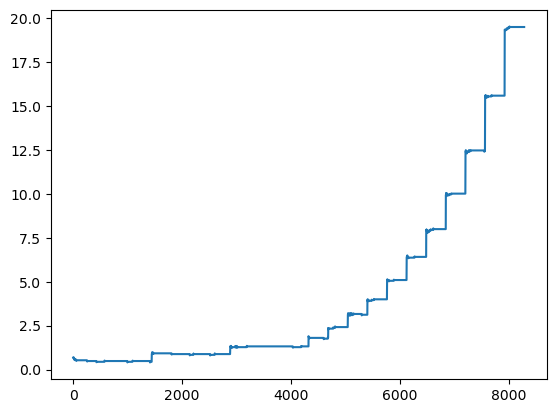

In [11]:
## CELL 2C
## INSTRUCTIONS: Run this cell

plt.plot(radar.elevation['data'])

## Activity 3: Plotting radar data with matplotlib<a class="anchor" id="step3"></a>
[Top](#top)

We know have a Level 2 radar file loaded into memory and can explore its metadata. For the last section, let's actually look through the data!

{todo discussion of polar coordinates and how we handle radar grid cells in matplotlib}

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    todo: CVD-friendly colormap, with link to options in pyart and general info on colormap choices
</div>

### Activity 3a: Plotting radar data with matplotlib<a class="anchor" id="step3a"></a>
[Top](#top)

{todo briefly explain a) the CRS we are using, b) Py-ART's concept of sweeps, and c) `get_gate_x_y_z`}

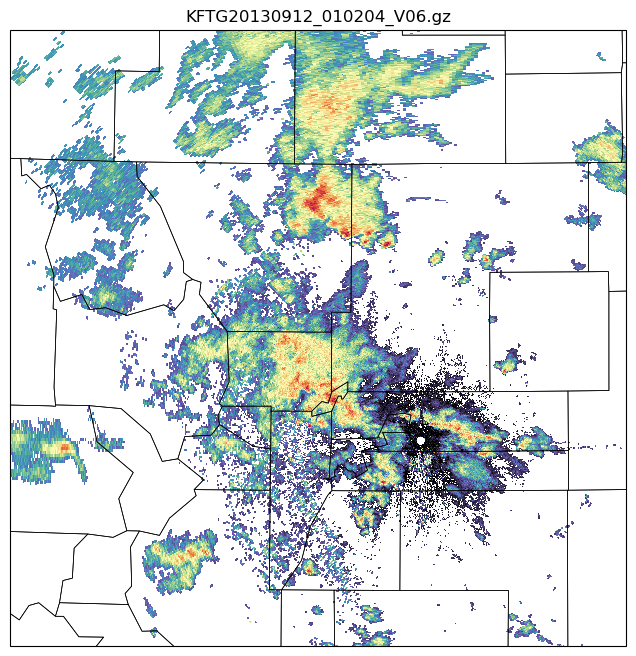

In [ ]:
## CELL 3A
## INSTRUCTIONS: Run this cell

crs = ccrs.AzimuthalEquidistant(
    central_longitude=radar.longitude['data'].item(),
    central_latitude=radar.latitude['data'].item()
)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': crs})
sweep = radar.extract_sweeps([0])
x, y, z = sweep.get_gate_x_y_z(0)

ax.pcolormesh(x, y, sweep.fields['reflectivity']['data'], cmap='pyart_ChaseSpectral', vmin=-10, vmax=70)
ax.add_feature(USCOUNTIES, linewidth=0.5)
ax.set_extent([-2e5, 1e5, -1e5, 2e5], crs=crs)
ax.set_title(nearest.split('/')[-1])

plt.show()

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Make an Improved Plot of a Single Field</p>
    {todo prompt making a similar simple plot, but with a more meaningful title and/or other annotations, a colorbar, and setting the extents to encompass some feature of interest}
    {todo also suggest looking at something other than reflectivity if interested, with reference to pyart colormaps}
</div>

In [10]:
# ACTIVITY: Plot an Improved Plot of a Single Field
# Create your plot code below

### Activity 3b: Plotting mulitple scans/moments<a class="anchor" id="step3b"></a>
[Top](#top)

{todo show example}

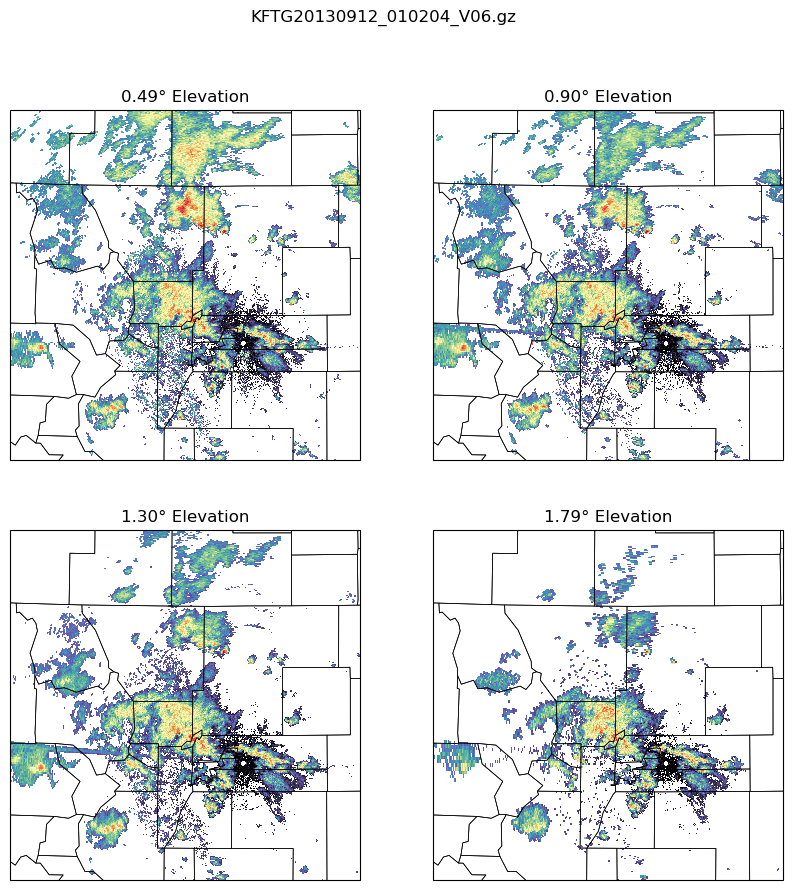

In [28]:
## CELL 3B
## INSTRUCTIONS: Run this cell

crs = ccrs.AzimuthalEquidistant(
    central_longitude=radar.longitude['data'].item(),
    central_latitude=radar.latitude['data'].item()
)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': crs})

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        sweep_id = 4 * i + 2 * j
        sweep = radar.extract_sweeps([sweep_id])
        x, y, z = sweep.get_gate_x_y_z(0)

        ax.pcolormesh(x, y, sweep.fields['reflectivity']['data'], cmap='pyart_ChaseSpectral', vmin=-10, vmax=70)
        ax.add_feature(USCOUNTIES, linewidth=0.5)
        ax.set_extent([-2e5, 1e5, -1e5, 2e5], crs=crs)
        ax.set_title(f"{sweep.elevation['data'].mean():0.2f}\u00B0 Elevation")
        
fig.suptitle(nearest.split('/')[-1])

plt.show()

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Make a Multi-Panel Figure</p>
    {todo prompt making a multi-panel plot, be it multiple scans, fields, or even radar volumes}
</div>

In [12]:
# ACTIVITY: Plot a Multi-Panel Figure
# Create your plot code below

## Wrap-Up <a class="anchor" id="wrapup"></a>

{todo wrap-up}

{todo include list to other avenues for interested participants to explore next, such as pyart calculations, xradar for improved data model, how to use MRMS gridded mosaic radar data, etc.}